In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

df = pd.read_csv('train.csv', sep = ';')
df.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
8966,35,self-employed,married,tertiary,no,182,no,yes,unknown,5,jun,379,1,-1,0,unknown,no
6671,24,blue-collar,married,secondary,no,0,no,no,unknown,28,may,94,1,-1,0,unknown,no
5156,26,management,single,tertiary,no,1284,yes,no,unknown,21,may,97,8,-1,0,unknown,no
8841,27,admin.,married,secondary,no,-247,yes,yes,unknown,4,jun,344,2,-1,0,unknown,no
23129,31,management,single,tertiary,no,1,no,no,cellular,26,aug,107,5,-1,0,unknown,no


In [2]:
cats = df.select_dtypes(include = ['object']).columns
nums = df.select_dtypes(include = ['int64', 'float64']).columns

cats, nums

(Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'poutcome', 'y'],
       dtype='object'),
 Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object'))

In [440]:
for i in nums:
    if (df[i] < 0).any():
        print(f'{i} contains {len(df[df[i] < 0])} negative values')

balance contains 3766 negative values
pdays contains 36954 negative values


In [441]:
print(f'Before removing outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))
for col in ['balance']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((df[col] >= low_limit) & (df[col] <= high_limit)) & filtered_entries
    
df = df[filtered_entries]

print(f'After removing outlier: {len(df)}')

Before removing outlier: 45211
After removing outlier: 40482


In [442]:
X = df.drop(columns=['y'])
y = df[['y']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 14)

In [443]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for i in list(X_train.select_dtypes(include = ['int64', 'float64']).columns):
    fitted = scaler.fit(X_train[[i]])
    X_train[i] = fitted.transform(X_train[[i]])
    X_test[i] = fitted.transform(X_test[[i]])

In [444]:
col = ['job', 'education', 'contact']

for i in col:
    print(f"{i} unknown: {round(len(df[df[i].isin(['unknown'])]) / len(df) * 100, 2)}%")

job unknown: 0.62%
education unknown: 4.04%
contact unknown: 29.26%


In [445]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

col = ['job', 'education']

for i in col:
    train[i] = train[i].replace('unknown', df[i].mode()[0])
    test[i] = test[i].replace('unknown', df[i].mode()[0])

X_train = train.drop(columns=['y'])
y_train = train[['y']]

X_test = test.drop(columns=['y'])
y_test = test[['y']]

In [446]:
col = ['job', 'education', 'contact']

for i in col:
    print(f"{i} unknown train set: {round(len(train[train[i].isin(['unknown'])]) / len(train) * 100, 2)}%")
    print(f"{i} unknown test set: {round(len(test[test[i].isin(['unknown'])]) / len(test) * 100, 2)}%")

job unknown train set: 0.0%
job unknown test set: 0.0%
education unknown train set: 0.0%
education unknown test set: 0.0%
contact unknown train set: 29.19%
contact unknown test set: 29.41%


In [447]:
X_train['education_mapped'] = X_train['education'].map({'primary' : 0,
                                                        'secondary' : 1,
                                                        'tertiary' : 2})

X_test['education_mapped'] = X_test['education'].map({'primary' : 0,
                                                      'secondary' : 1,
                                                      'tertiary' : 2})

X_train['is_default'] = X_train['default'].map({'no' : 0,
                                                'yes' : 1})

X_test['is_default'] = X_test['default'].map({'no' : 0,
                                              'yes' : 1})

X_train['is_housing'] = X_train['housing'].map({'no' : 0,
                                                'yes' : 1})

X_test['is_housing'] = X_test['housing'].map({'no' : 0,
                                              'yes' : 1})

X_train['is_loan'] = X_train['loan'].map({'no' : 0,
                                          'yes' : 1})

X_test['is_loan'] = X_test['loan'].map({'no' : 0,
                                        'yes' : 1})

y_train['y'] = y_train['y'].map({'no' : 0,
                                 'yes' : 1})

y_test['y'] = y_test['y'].map({'no' : 0,
                               'yes' : 1})

In [448]:
for i in ['job', 'marital']:
    X_train = pd.concat([X_train, pd.get_dummies(X_train[i], prefix = i)], axis = 1)
    X_test = pd.concat([X_test, pd.get_dummies(X_test[i], prefix = i)], axis = 1)

In [449]:
X_train = X_train.drop(columns = list(X_train.select_dtypes(include = ['object']).columns) + ['contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome'])
X_test = X_test.drop(columns = list(X_test.select_dtypes(include = ['object']).columns) + ['contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome'])

In [468]:
X_train.columns, display(len(X_train.columns))

20

(Index(['age', 'balance', 'education_mapped', 'is_default', 'is_housing',
        'is_loan', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
        'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
        'job_services', 'job_student', 'job_technician', 'job_unemployed',
        'marital_divorced', 'marital_married', 'marital_single'],
       dtype='object'),
 None)

In [450]:
from imblearn import over_sampling

X_train_over, y_train_over = over_sampling.SMOTE(random_state = 14).fit_resample(X_train, y_train)

In [451]:
len(X_train_over), len(y_train_over), len(X_train), len(y_train), len(X_test), len(y_test)

(50262, 50262, 28337, 28337, 12145, 12145)

In [452]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

def eval_classification():
    
    list_model = {'Logistic Regression' : LogisticRegression(random_state = 14),
                  'KNN Classifier' : KNeighborsClassifier(),
                  'Decision Tree Classifier' : DecisionTreeClassifier(random_state = 14),
                  'Random Forest Classifier' : RandomForestClassifier(random_state = 14),
                  'AdaBoost Classifier' : AdaBoostClassifier(random_state = 14),
                  'XGBoost Classifier' : XGBClassifier(random_state = 14)}
    
    for key, val in list_model.items():
        model = val
        model.fit(X_train_over, y_train_over)
    
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        y_pred_proba = model.predict_proba(X_test)
        y_pred_proba_train = model.predict_proba(X_train)

        print(key, "Evaluation Result")
        print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
        print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
        print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
        print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
        print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
        print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
        print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
        print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
        print("")

In [453]:
eval_classification()

Logistic Regression Evaluation Result
Accuracy (Train Set): 0.64
Accuracy (Test Set): 0.63
Precision (Train Set): 0.18
Precision (Test Set): 0.17
Recall (Train Set): 0.62
Recall (Test Set): 0.61
F1-Score (Train Set): 0.28
F1-Score (Test Set): 0.27

KNN Classifier Evaluation Result
Accuracy (Train Set): 0.82
Accuracy (Test Set): 0.70
Precision (Train Set): 0.37
Precision (Test Set): 0.18
Recall (Train Set): 0.90
Recall (Test Set): 0.50
F1-Score (Train Set): 0.53
F1-Score (Test Set): 0.26

Decision Tree Classifier Evaluation Result
Accuracy (Train Set): 0.99
Accuracy (Test Set): 0.79
Precision (Train Set): 0.99
Precision (Test Set): 0.20
Recall (Train Set): 0.91
Recall (Test Set): 0.33
F1-Score (Train Set): 0.95
F1-Score (Test Set): 0.25

Random Forest Classifier Evaluation Result
Accuracy (Train Set): 0.99
Accuracy (Test Set): 0.79
Precision (Train Set): 0.94
Precision (Test Set): 0.22
Recall (Train Set): 0.95
Recall (Test Set): 0.36
F1-Score (Train Set): 0.95
F1-Score (Test Set): 0.27


In [454]:
from sklearn.model_selection import GridSearchCV

params = {"penalty": ['l1', 'l2'],
          "C":[0.001,0.01,0.1,1,10,100]}

model = GridSearchCV(LogisticRegression(random_state = 14), 
                   param_grid = params, 
                   cv = 10, 
                   scoring = 'recall')

model.fit(X_train_over, y_train_over)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred_proba = model.predict_proba(X_test)
y_pred_proba_train = model.predict_proba(X_train)

print(f'Best Parameter: {model.best_params_}')
print("Best Score: %.2f" % model.best_score_)
print('')

print("Tuned Logistic Regression")
print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

Best Parameter: {'C': 0.001, 'penalty': 'l2'}
Best Score: 0.65

Tuned Logistic Regression
Accuracy (Train Set): 0.63
Accuracy (Test Set): 0.62
Precision (Train Set): 0.18
Precision (Test Set): 0.17
Recall (Train Set): 0.64
Recall (Test Set): 0.63
F1-Score (Train Set): 0.28
F1-Score (Test Set): 0.27


In [459]:
from sklearn.model_selection import KFold, RandomizedSearchCV

model = AdaBoostClassifier(random_state = 14)

rand = dict()
rand['n_estimators'] = [700, 800, 900]
rand['algorithm'] = ['SAMME', 'SAMME.R']
rand['base_estimator'] = [LogisticRegression(C = 0.001, penalty = 'l2', random_state = 14)]

cv = KFold(n_splits=10)
rand_search = RandomizedSearchCV(estimator=model, param_distributions=rand, n_jobs=-1, cv=cv, scoring='recall')
rand_result = rand_search.fit(X_train_over, y_train_over)
y_pred = rand_result.predict(X_test)
y_pred_train = rand_result.predict(X_train)
y_pred_proba = rand_result.predict_proba(X_test)
y_pred_proba_train = rand_result.predict_proba(X_train)

print(f'Best Parameter: {rand_result.best_params_}')
print(f'Best Score: {rand_result.best_score_}')
print('')

print("Tuned Adaboost Classifier")
print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

Best Parameter: {'n_estimators': 700, 'base_estimator': LogisticRegression(C=0.001, random_state=14), 'algorithm': 'SAMME'}
Best Score: 0.6345940432071374

Tuned Adaboost Classifier
Accuracy (Train Set): 0.57
Accuracy (Test Set): 0.56
Precision (Train Set): 0.16
Precision (Test Set): 0.15
Recall (Train Set): 0.69
Recall (Test Set): 0.67
F1-Score (Train Set): 0.27
F1-Score (Test Set): 0.25


Text(1.9722222222222232, 0.5, 'Actual')

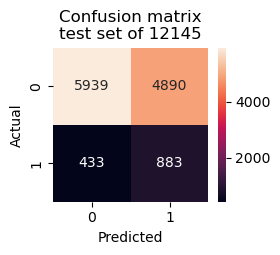

In [465]:
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize = (2.5,2))
sns.heatmap((confusion_matrix(y_test, y_pred)), annot = True, fmt = '.0f', ax = fig.add_subplot(1,1, 1))
plt.title(f'Confusion matrix\ntest set of {len(y_test)}')
plt.xlabel('Predicted')
plt.ylabel('Actual')